In [716]:
'''
Exercise 2.5 (programming) Design and conduct an experiment to demonstrate the
diculties that sample-average methods have for nonstationary problems. Use a modified
version of the 10-armed testbed in which all the q⇤(a) start out equal and then take
independent random walks (say by adding a normally distributed increment with mean 0
and standard deviation 0.01 to all the q⇤(a) on each step). Prepare plots like Figure 2.2
for an action-value method using sample averages, incrementally computed, and another
action-value method using a constant step-size parameter, alpha = 0.1. Use epsilon = 0.1 and
longer runs, say of 10,000 steps.
'''

'\nExercise 2.5 (programming) Design and conduct an experiment to demonstrate the\ndiculties that sample-average methods have for nonstationary problems. Use a modified\nversion of the 10-armed testbed in which all the q⇤(a) start out equal and then take\nindependent random walks (say by adding a normally distributed increment with mean 0\nand standard deviation 0.01 to all the q⇤(a) on each step). Prepare plots like Figure 2.2\nfor an action-value method using sample averages, incrementally computed, and another\naction-value method using a constant step-size parameter, alpha = 0.1. Use epsilon = 0.1 and\nlonger runs, say of 10,000 steps.\n'

In [718]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


In [719]:
norm_update_mean = 0
norm_update_std = .01
initial_q_mean = 0
bandit_val_std = 1
bandits = 10
cycles = 100
trial_steps = 10000
test_alpha = .1
test_epsilon = .1

In [720]:
class Action:

    def __init__(self, name,initial_mean, bandit_val_std):
        self.name = 'Action {}'.format(name)
        self.initial_mean =  initial_mean
        self.initial_std = bandit_val_std
        self.initial = np.random.normal(initial_mean, bandit_val_std)
        self.value = self.initial
        self.count = 0

    def return_val(self): 
        value_sample = np.random.normal(self.value, self.initial_std)
        return value_sample

    def update(self, mean, std):
        self.value += np.random.normal(mean,std) #these will receive inputs that are specified above, 0 and .01
        

    def reset(self):
        self.initial = np.random.normal(self.initial_mean, self.initial_std)
        self.value = self.initial
        self.count = 0
        #to be done at the end of the iterations


In [721]:

class Agent:

    def __init__ (self, alpha, epsilon, steps, incremental_q = True, c=0 ):
        self.alpha = alpha  # for value updating functions
        self.epsilon = epsilon # for value updating functions
        self.step_count = 0 # keeping track of steps we've taken
        self.steps = steps
        self.incremental_q = incremental_q
        self.rewards = np.zeros(steps) # store reward at each step
        self.actions = np.zeros(steps) # store action taken at each step
        self.optimals = np.zeros(steps) # store whether optimal decision was taken at each step
                                        #At each step, we should catalogue the value of each Action
                                        #And create a variable that is the optimal Action (max value)
        self.qa_rewards = np.zeros(bandits) # for storing the expected value of each action
        self.k_counts = np.zeros(bandits) #store the number of times each action is taken
        self.expr_explore_prob = c

    def first_pulls(self):
        pulls = list()
        for i in range(0,bandits):
            pulls.append(i)
        np.random.shuffle(pulls)
        for action_index in pulls:
            reward = objs[action_index].return_val()
            self.rewards[self.step_count] = reward
            self.actions[self.step_count] = action_index
            
            self.qa_rewards[action_index] = reward
            self.k_counts[action_index] += 1
            self.step_count += 1
            objs[action_index].update(norm_update_mean,norm_update_std) #probably not the best to refer to a list that might not be created or named differently but OK for short assignment
            objs[action_index].count += 1
    
    def increment_q(self, action, reward):
        # Q(k+1) = Q(k) + (1/k)*[R(k)-Q(k)]
        self.qa_rewards[action] = self.qa_rewards[action] + (1/objs[action].count)*(reward-self.qa_rewards[action])

    def step_q(self, action, reward):
        #Q(k+1) = Q(k) + alpha[R(k) - Q(k)]
        self.qa_rewards[action] = self.qa_rewards[action] + self.alpha*(reward-self.qa_rewards[action])


    def choose_policy(self):
        cutoff = 10000*(1-self.epsilon)
        roll = np.random.randint(1,10001)
        if roll < cutoff:
            return True # we will exploit
        return False #we will explore
        

    def explore(self):
        rand_action = np.random.randint(0,bandits)
        self.actions[self.step_count] = rand_action
        reward = objs[rand_action].return_val()
        self.rewards[self.step_count] = reward
        self.k_counts[rand_action] += 1
        self.step_count += 1
        objs[rand_action].count += 1
        if self.incremental_q:
            self.increment_q(rand_action, reward)
        else:
            self.step_q(rand_action,reward)
        for i in range(0,len(objs)):
            objs[i].update(norm_update_mean,norm_update_std)
        
    def expr_explore(self):
        cutoff = 10000*(1-self.expr_explore_prob)
        roll = np.random.randint(1,10001)
        if roll < cutoff:
            self.explore()
        else:
            highest_qas =list() ##Stores our 5 highest expected values/actions
            top_indexes = list() #stores the index of our 5 highest expecated values/actions 
            for qa in range(0,int(len(self.qa_rewards)/2)):
                highest_qas.append(sorted(self.qa_rewards, reverse=True)[qa])
            for i in highest_qas:
                top_indexes.append(np.where(self.qa_rewards==i)[0][0])
            #now we need to randomly pick a value from this list, which will be the action we take
            top_indexes = np.array(top_indexes)
            np.random.shuffle(top_indexes) #shuffle the top indexes
            rand_action = top_indexes[0] #take the first one after it was randomized. this is now our new random action to explore
            #now just copy the .explore() method
            self.actions[self.step_count] = rand_action
            reward = objs[rand_action].return_val()
            self.rewards[self.step_count] = reward
            self.k_counts[rand_action] += 1
            self.step_count += 1
            objs[rand_action].count += 1
            if self.incremental_q:
                self.increment_q(rand_action, reward)
            else:
                self.step_q(rand_action,reward)
            for i in range(0,len(objs)):
                objs[i].update(norm_update_mean,norm_update_std)

    
    def exploit(self):
        # we will take the value of the action # where Qa_action is highest
        # update each array
        action = np.where(self.qa_rewards == max(self.qa_rewards))[0][0]
        self.actions[self.step_count] = action
        reward = objs[action].return_val()
        self.rewards[self.step_count] = reward
        self.k_counts[action] += 1
        self.step_count += 1
        objs[action].count += 1
        if self.increment_q:
            self.increment_q(action, reward)
        else:
            self.step_q(action, reward)
        for i in range(0,len(objs)):
            objs[i].update(norm_update_mean,norm_update_std)

    def reset(self):
        #we will reset all the arrays, to bedone after adding each array to a global array for graphing
        self.step_count = 0 # keeping track of steps we've taken
        self.rewards = np.zeros(self.steps) # store reward at each step
        self.actions = np.zeros(self.steps) # store action taken at each step
        self.optimals = np.zeros(self.steps) # store whether optimal decision was taken at each step
                                        #At each step, we should catalogue the value of each Action
                                        #And create a variable that is the optimal Action (max value)
        self.qa_rewards = np.zeros(bandits) # for storing the expected value of each action
        self.k_counts = np.zeros(bandits) #store the number of times each action is taken




In [722]:
incr_test_agent = Agent(alpha=test_alpha,epsilon= test_epsilon, steps=trial_steps, incremental_q=True) #initiate the Agent with desired attributes
incr_all_rewards = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)  #This keeps track of each reward we receive at each trial step
incr_all_actions = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)  #this keeps track of each action taken at each trial step
incr_all_optimals = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps) #this keeps track of whether we chose the optimal action at each trial step
incr_final_qas = np.zeros(cycles*bandits).reshape(cycles,bandits)  #this keeps track of our final estimated value of each arm
incr_all_k_counts = np.zeros(cycles*bandits).reshape(cycles,bandits)  #this keeps track of how many times each action was taken
incr_final_true_values = np.zeros(cycles*bandits).reshape(cycles,bandits)  #this keeps track of the final value of each arm
test_test_policy = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps) # I want to see if we are exploring/exploiting right

In [723]:
#initialize all our Actions. This is a list with k bandits in it where each bandit is an instance of an Action class
objs = list()
for i in range(0,bandits):
    objs.append(Action(i,initial_q_mean, bandit_val_std))

In [724]:
np.random.seed(42)
for i in range(0,cycles):
    incr_test_agent.first_pulls() #initialize the process by pulling each action once

    while incr_test_agent.step_count < trial_steps:
        #I need to determine first what is the best action for each step so we can keep track of optimal actions
        bandit_true_values = list()
        for bandit in objs:
            bandit_true_values.append(bandit.value)  #add each bandits true value to a list 
        optimal_action_index = bandit_true_values.index(max(bandit_true_values))  #find the index of that list where it is the highest (highest value)

        if incr_test_agent.choose_policy(): #if true, it will exploit
            test_test_policy[i][incr_test_agent.step_count] = 1
            incr_test_agent.exploit()  #this determines the action index where the qa_rewards array is highest, logs that we are taking that action, generates a reward, logs the reward, increases count of that action and step count
                                        #  checks if increment_q == true, then does the 1/n alpha, or 1/alpha alpha for the Q(a) function, then runs Action.update() for each arm
            if incr_test_agent.actions[incr_test_agent.step_count-1] == optimal_action_index: #the explore/eploit methods automatically increment the step count, so we take the previous step count number and check if it our actions array
                incr_test_agent.optimals[incr_test_agent.step_count-1] = 1 #shows that we took the optimal action at that step, if yes, it puts a 1 in for hte optimal array at that step to keep track      
        else:
            incr_test_agent.explore() #these two methods update all the arrays and actions
            if incr_test_agent.actions[incr_test_agent.step_count-1] == optimal_action_index:
                incr_test_agent.optimals[incr_test_agent.step_count-1] = 1
    incr_all_rewards[i] = incr_test_agent.rewards ### update all the final data collection arrays at each cycle
    incr_all_actions[i] = incr_test_agent.actions
    incr_all_optimals[i] = incr_test_agent.optimals
    incr_final_qas[i] = incr_test_agent.qa_rewards
    incr_all_k_counts[i] = incr_test_agent.k_counts
    final_bandit_vals = list()
    for bandit in objs:
        final_bandit_vals.append(bandit.value)
    final_bandit_vals = np.array(final_bandit_vals)
    incr_final_true_values[i] = final_bandit_vals
    incr_test_agent.reset()
    for bandit in objs:
        bandit.reset()       
        


In [725]:
incr_average_rewards = list()
for i in range(0,len(incr_all_rewards)):
    incr_average_rewards.append(sum(incr_all_rewards[i])/trial_steps)
print(min(incr_average_rewards))
print(max(incr_average_rewards))
print(sum(incr_average_rewards)/cycles)


-0.19556249182155427
3.8897519188477374
1.603003165773835


In [726]:
incr_optimal_counts = list()
for i in range(0,len(incr_all_optimals)):
    incr_optimal_counts.append(sum(incr_all_optimals[i]))
print(min(incr_optimal_counts))
print(max(incr_optimal_counts))
print(sum(incr_optimal_counts)/cycles/trial_steps)


521.0
9132.0
0.657346


In [727]:
incr_exploit_counts = list()
for i in range(0,len(test_test_policy)):
    incr_exploit_counts.append(sum(test_test_policy[i]))
print(min(incr_exploit_counts))
print(max(incr_exploit_counts))
print(sum(incr_exploit_counts)/cycles/trial_steps)


8922.0
9048.0
0.898761


In [728]:
'''
re-run the process to get data for using step-size parameter alpha instead of simple average
'''

'\nre-run the process to get data for using step-size parameter alpha instead of simple average\n'

In [729]:
astep_test_agent = Agent(alpha=test_alpha,epsilon=test_epsilon, steps=trial_steps, incremental_q=False)
astep_all_rewards = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)
astep_all_actions = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)
astep_all_optimals = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)
astep_final_qas = np.zeros(cycles*bandits).reshape(cycles,bandits)
astep_all_k_counts = np.zeros(cycles*bandits).reshape(cycles,bandits)
astep_final_true_values = np.zeros(cycles*bandits).reshape(cycles,bandits)

In [730]:
#initialize all our Actions. This is a list with k bandits in it where each bandit is an instance of an Action class
objs = list()
for i in range(0,bandits):
    objs.append(Action(i,initial_q_mean, bandit_val_std))

In [731]:
np.random.seed(42)
for i in range(0,cycles):
    astep_test_agent.first_pulls() #initialize the process by pulling each action once
    while astep_test_agent.step_count < trial_steps:
        #I need to determine first what is the best action for each step so we can keep track of optimal actions
        bandit_true_values = list()
        for bandit in objs:
            bandit_true_values.append(bandit.value)
        optimal_action_index = bandit_true_values.index(max(bandit_true_values))

        if astep_test_agent.choose_policy(): #if true, it will exploit
            astep_test_agent.exploit()
            if astep_test_agent.actions[astep_test_agent.step_count-1] == optimal_action_index: #the explore/eploit methods automatically increment the step count, so we take the previous step count number and check if it our actions array
                astep_test_agent.optimals[astep_test_agent.step_count-1] = 1 #shows that we took the optimal action at that step, if yes, it puts a 1 in for hte optimal array at that step to keep track
        else:
            astep_test_agent.explore() #these two methods update all the arrays and actions
            if astep_test_agent.actions[astep_test_agent.step_count-1] == optimal_action_index:
                astep_test_agent.optimals[astep_test_agent.step_count-1] = 1
    astep_all_rewards[i] = astep_test_agent.rewards
    astep_all_actions[i] = astep_test_agent.actions
    astep_all_optimals[i] = astep_test_agent.optimals
    astep_final_qas[i] = astep_test_agent.qa_rewards
    astep_all_k_counts[i] = astep_test_agent.k_counts
    final_bandit_vals = list()
    for bandit in objs:
        final_bandit_vals.append(bandit.value)
    final_bandit_vals = np.array(final_bandit_vals)
    astep_final_true_values[i] = final_bandit_vals
    astep_test_agent.reset()
    for bandit in objs:
        bandit.reset()       
        


In [732]:
astep_average_rewards = list()
for i in range(0,len(astep_all_rewards)):
    astep_average_rewards.append(sum(astep_all_rewards[i])/trial_steps)
print(min(astep_average_rewards))
print(max(astep_average_rewards))
print(sum(astep_average_rewards)/cycles)


-0.10754284170383294
3.8897519188477374
1.6605735878407655


In [733]:
astep_optimal_counts = list()
for i in range(0,len(astep_all_optimals)):
    astep_optimal_counts.append(sum(astep_all_optimals[i]))
print(min(astep_optimal_counts))
print(max(astep_optimal_counts))
print(sum(astep_optimal_counts)/cycles/trial_steps)

2949.0
9132.0
0.730773


In [734]:
x_axis_steps = np.arange(0,trial_steps)

In [735]:
incr_avg_average_rewards = np.zeros(trial_steps)
for i in range(0,len(incr_all_rewards.transpose())):
    incr_avg_average_rewards[i] = sum(incr_all_rewards.transpose()[i])/cycles
incr_avg_average_rewards[0:20]

astep_avg_average_rewards = np.zeros(trial_steps)
for i in range(0,len(astep_all_rewards.transpose())):
    astep_avg_average_rewards[i] = sum(astep_all_rewards.transpose()[i])/100



C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


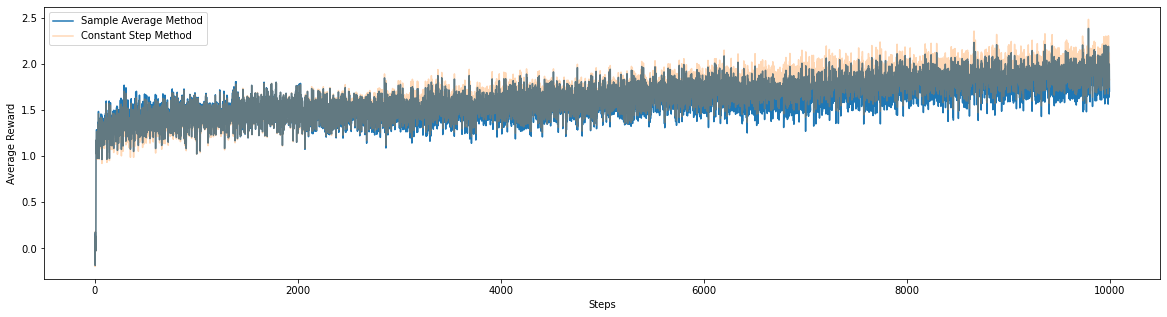

In [736]:
from cProfile import label


plt.figure(figsize=(20,5))
sns.lineplot(x_axis_steps,incr_avg_average_rewards)
sns.lineplot(x_axis_steps, astep_avg_average_rewards, alpha = .3)
plt.xlabel('Steps')
plt.ylabel('Average Reward')

plt.legend(labels =['Sample Average Method','Constant Step Method'])
plt.show;

In [737]:
incr_optimal_percent = np.zeros(trial_steps)
for i in range(0,len(incr_all_optimals.transpose())):
    incr_optimal_percent[i] = sum(incr_all_optimals.transpose()[i])/100
incr_optimal_percent[0:20]

astep_optimal_percent = np.zeros(trial_steps)
for i in range(0,len(astep_all_optimals.transpose())):
    astep_optimal_percent[i] = sum(astep_all_optimals.transpose()[i])/100



C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


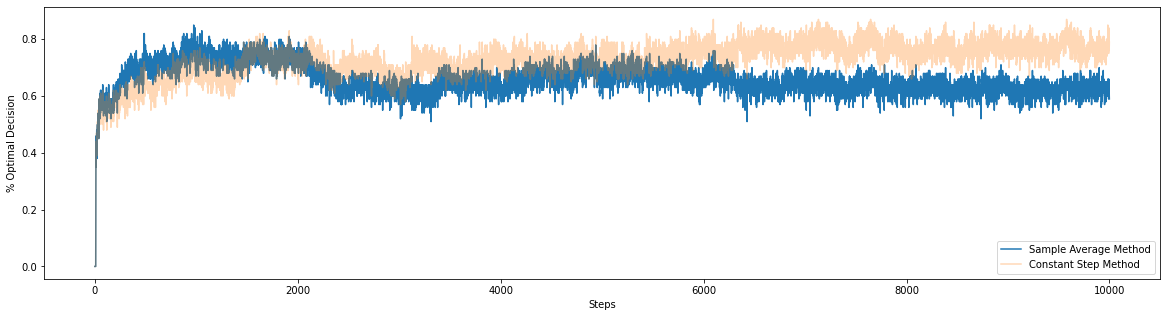

In [738]:
plt.figure(figsize=(20,5))
sns.lineplot(x_axis_steps,incr_optimal_percent)
sns.lineplot(x_axis_steps, astep_optimal_percent, alpha = .3)
plt.xlabel('Steps')
plt.ylabel('% Optimal Decision')
plt.legend(labels =['Sample Average Method','Constant Step Method'])
plt.show;

In [739]:
data_table = pd.DataFrame({
    'Model': ['Simple Average Method','Constant Step-Size Method'], 'Average Reward' : [sum(incr_average_rewards)/len(incr_average_rewards), 
    sum(astep_average_rewards)/len(astep_average_rewards)],
    'Average Optimal Action Percentage' : [sum(incr_optimal_counts)/cycles/len(incr_optimal_counts), sum(astep_optimal_counts)/cycles/len(astep_optimal_counts)]

})

our experiement is this: Can we improve the average reward of the agent over 10,000 steps if we modify the exploration method as such:
We explore with probability epsilon
When exploring, we choose randomly from our top 5 highest q(a) actions with probability c and with probability (1-c) we explore completely randomly (normal exploration).

For testing, we will use sample averages for our q(a) functions for simplicity. 


In [740]:
#create simulation for the new agent we will call expr_test_agent (and create required arrays)
expr_test_agent = Agent(alpha=test_alpha,epsilon=test_epsilon, steps=trial_steps, incremental_q=True, c=.5)
expr_all_rewards = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)
expr_all_actions = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)
expr_all_optimals = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)
expr_final_qas = np.zeros(cycles*bandits).reshape(cycles,bandits)
expr_all_k_counts = np.zeros(cycles*bandits).reshape(cycles,bandits)
expr_final_true_values = np.zeros(cycles*bandits).reshape(cycles,bandits)

In [741]:
#initialize all our Actions. This is a list with k bandits in it where each bandit is an instance of an Action class
objs = list()
for i in range(0,bandits):
    objs.append(Action(i,initial_q_mean, bandit_val_std))

In [742]:
#we need to modify the simulation slightly to do .expr_eplore() instead of .explore()
np.random.seed(42)
for i in range(0,cycles):
    expr_test_agent.first_pulls() #initialize the process by pulling each action once
    while expr_test_agent.step_count < trial_steps:
        #I need to determine first what is the best action for each step so we can keep track of optimal actions
        bandit_true_values = list()
        for bandit in objs:
            bandit_true_values.append(bandit.value)
        optimal_action_index = bandit_true_values.index(max(bandit_true_values))

        if expr_test_agent.choose_policy(): #if true, it will exploit
            expr_test_agent.exploit()
            if expr_test_agent.actions[expr_test_agent.step_count-1] == optimal_action_index: #the explore/eploit methods automatically increment the step count, so we take the previous step count number and check if it our actions array
                expr_test_agent.optimals[expr_test_agent.step_count-1] = 1 #shows that we took the optimal action at that step, if yes, it puts a 1 in for hte optimal array at that step to keep track
        else:
            expr_test_agent.expr_explore() #these two methods update all the arrays and actions
            if expr_test_agent.actions[expr_test_agent.step_count-1] == optimal_action_index:
                expr_test_agent.optimals[expr_test_agent.step_count-1] = 1
    expr_all_rewards[i] = expr_test_agent.rewards
    expr_all_actions[i] = expr_test_agent.actions
    expr_all_optimals[i] = expr_test_agent.optimals
    expr_final_qas[i] = expr_test_agent.qa_rewards
    expr_all_k_counts[i] = expr_test_agent.k_counts
    final_bandit_vals = list()
    for bandit in objs:
        final_bandit_vals.append(bandit.value)
    final_bandit_vals = np.array(final_bandit_vals)
    expr_final_true_values[i] = final_bandit_vals
    expr_test_agent.reset()
    for bandit in objs:
        bandit.reset()       
        


In [743]:
expr_average_rewards = list()
for i in range(0,len(expr_all_rewards)):
    expr_average_rewards.append(sum(expr_all_rewards[i])/trial_steps)
print(min(expr_average_rewards))
print(max(expr_average_rewards))
print(sum(expr_average_rewards)/cycles)


0.06463969160105554
3.600864633782232
1.6523202618565378


In [744]:
expr_optimal_counts = list()
for i in range(0,len(expr_all_optimals)):
    expr_optimal_counts.append(sum(expr_all_optimals[i]))
print(min(expr_optimal_counts))
print(max(expr_optimal_counts))
print(sum(expr_optimal_counts)/cycles/trial_steps)

1604.0
9180.0
0.672424


In [745]:

expr_avg_average_rewards = np.zeros(trial_steps)
for i in range(0,len(expr_all_rewards.transpose())):
    expr_avg_average_rewards[i] = sum(expr_all_rewards.transpose()[i])/cycles



C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


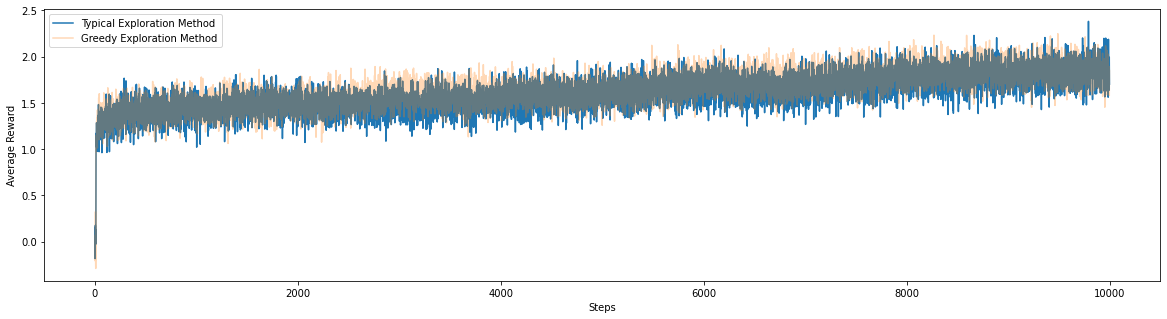

In [746]:
from cProfile import label


plt.figure(figsize=(20,5))
sns.lineplot(x_axis_steps,incr_avg_average_rewards)
sns.lineplot(x_axis_steps, expr_avg_average_rewards, alpha = .3)
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend(labels =['Typical Exploration Method','Greedy Exploration Method'])
plt.show;

In [747]:
expr_optimal_percent = np.zeros(trial_steps)
for i in range(0,len(expr_all_optimals.transpose())):
    expr_optimal_percent[i] = sum(expr_all_optimals.transpose()[i])/100

C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


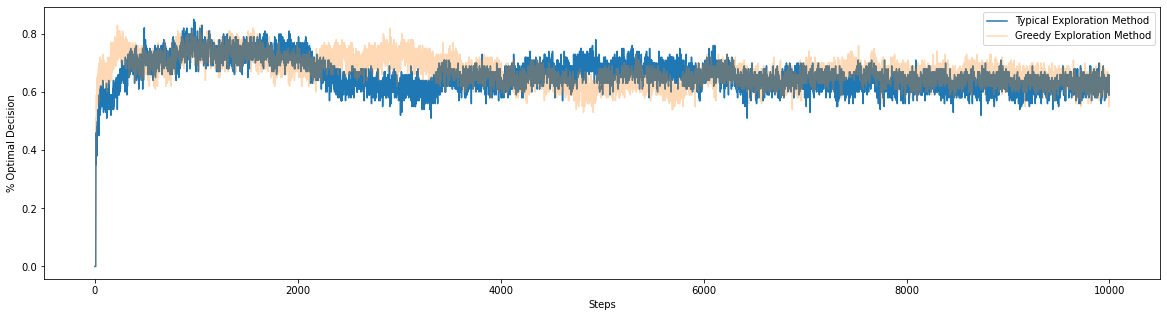

In [792]:
plt.figure(figsize=(20,5))
sns.lineplot(x_axis_steps,incr_optimal_percent)
sns.lineplot(x_axis_steps, expr_optimal_percent, alpha = .3)
#sns.lineplot(x_axis_steps, astep_optimal_percent, alpha = .3)
plt.xlabel('Steps')
plt.ylabel('% Optimal Decision')
plt.legend(labels =['Typical Exploration Method','Greedy Exploration Method', 'Constant Step Size'])
plt.show;

In [749]:
#Lets Run the experiment one more time, this time using the constant step size action-value function and greedy exploration

In [750]:
#create simulation for the new agent we will call astep_expr_test_agent (and create required arrays)
astep_expr_test_agent = Agent(alpha=test_alpha,epsilon=test_epsilon, steps=trial_steps, incremental_q=False, c=.5)
astep_expr_all_rewards = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)
astep_expr_all_actions = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)
astep_expr_all_optimals = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)
astep_expr_final_qas = np.zeros(cycles*bandits).reshape(cycles,bandits)
astep_expr_all_k_counts = np.zeros(cycles*bandits).reshape(cycles,bandits)
astep_expr_final_true_values = np.zeros(cycles*bandits).reshape(cycles,bandits)

In [751]:
#initialize all our Actions. This is a list with k bandits in it where each bandit is an instance of an Action class
objs = list()
for i in range(0,bandits):
    objs.append(Action(i,initial_q_mean, bandit_val_std))

In [752]:
#we need to modify the simulation slightly to do .expr_eplore() instead of .explore()
np.random.seed(42)
for i in range(0,cycles):
    astep_expr_test_agent.first_pulls() #initialize the process by pulling each action once
    while astep_expr_test_agent.step_count < trial_steps:
        #I need to determine first what is the best action for each step so we can keep track of optimal actions
        bandit_true_values = list()
        for bandit in objs:
            bandit_true_values.append(bandit.value)
        optimal_action_index = bandit_true_values.index(max(bandit_true_values))

        if astep_expr_test_agent.choose_policy(): #if true, it will exploit
            astep_expr_test_agent.exploit()
            if astep_expr_test_agent.actions[astep_expr_test_agent.step_count-1] == optimal_action_index: #the explore/eploit methods automatically increment the step count, so we take the previous step count number and check if it our actions array
                astep_expr_test_agent.optimals[astep_expr_test_agent.step_count-1] = 1 #shows that we took the optimal action at that step, if yes, it puts a 1 in for hte optimal array at that step to keep track
        else:
            astep_expr_test_agent.expr_explore() #these two methods update all the arrays and actions
            if astep_expr_test_agent.actions[astep_expr_test_agent.step_count-1] == optimal_action_index:
                astep_expr_test_agent.optimals[astep_expr_test_agent.step_count-1] = 1
    astep_expr_all_rewards[i] = astep_expr_test_agent.rewards
    astep_expr_all_actions[i] = astep_expr_test_agent.actions
    astep_expr_all_optimals[i] = astep_expr_test_agent.optimals
    astep_expr_final_qas[i] = astep_expr_test_agent.qa_rewards
    astep_expr_all_k_counts[i] = astep_expr_test_agent.k_counts
    final_bandit_vals = list()
    for bandit in objs:
        final_bandit_vals.append(bandit.value)
    final_bandit_vals = np.array(final_bandit_vals)
    astep_expr_final_true_values[i] = final_bandit_vals
    astep_expr_test_agent.reset()
    for bandit in objs:
        bandit.reset()       
        


In [753]:
astep_expr_average_rewards = list()
for i in range(0,len(astep_expr_all_rewards)):
    astep_expr_average_rewards.append(sum(astep_expr_all_rewards[i])/trial_steps)
print(min(astep_expr_average_rewards))
print(max(astep_expr_average_rewards))
print(sum(astep_expr_average_rewards)/cycles)


0.441522410468464
3.6030307354113384
1.737223340793452


In [754]:
astep_expr_optimal_counts = list()
for i in range(0,len(astep_expr_all_optimals)):
    astep_expr_optimal_counts.append(sum(astep_expr_all_optimals[i]))
print(min(astep_expr_optimal_counts))
print(max(astep_expr_optimal_counts))
print(sum(astep_expr_optimal_counts)/cycles/trial_steps)

4606.0
9180.0
0.766574


In [755]:
astep_expr_avg_average_rewards = np.zeros(trial_steps)
for i in range(0,len(astep_expr_all_rewards.transpose())):
    astep_expr_avg_average_rewards[i] = sum(astep_expr_all_rewards.transpose()[i])/cycles

astep_expr_optimal_percent = np.zeros(trial_steps)
for i in range(0,len(astep_expr_all_optimals.transpose())):
    astep_expr_optimal_percent[i] = sum(astep_expr_all_optimals.transpose()[i])/100

C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:

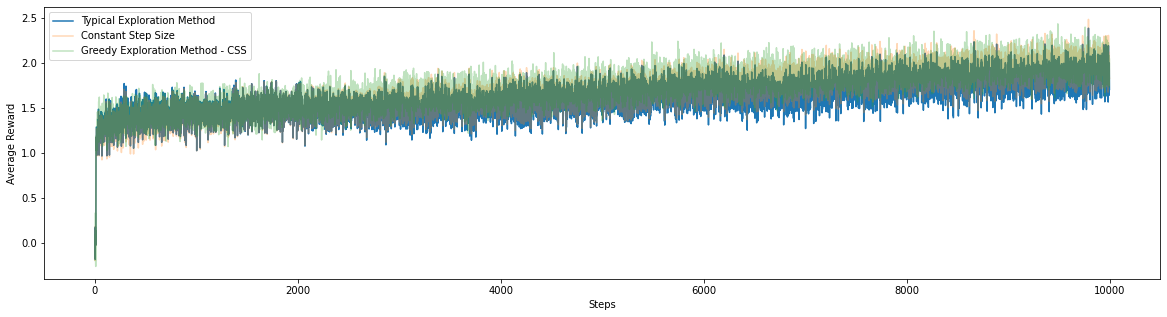

In [756]:
from cProfile import label


plt.figure(figsize=(20,5))
sns.lineplot(x_axis_steps,incr_avg_average_rewards)
#sns.lineplot(x_axis_steps, expr_avg_average_rewards, alpha = .3)
sns.lineplot(x_axis_steps, astep_avg_average_rewards, alpha = .3)
sns.lineplot(x_axis_steps, astep_expr_avg_average_rewards, alpha = .3)
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend(labels =['Typical Exploration Method',#'Greedy Exploration Method', 
'Constant Step Size','Greedy Exploration Method - CSS'])
plt.show;

C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:

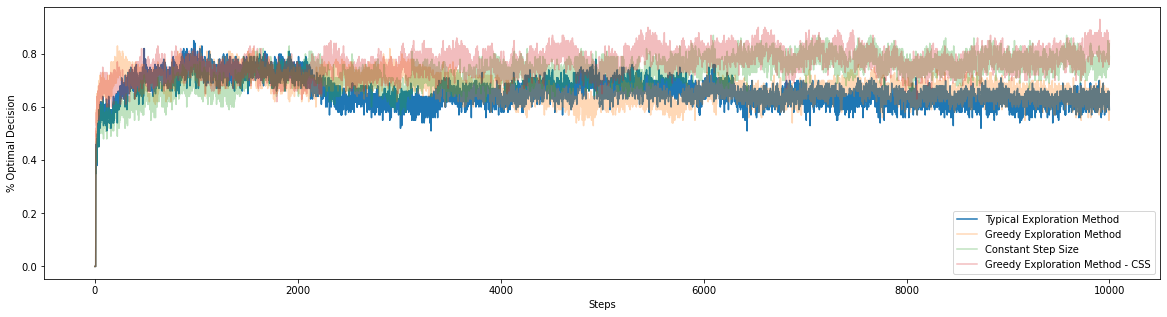

In [757]:
plt.figure(figsize=(20,5))
sns.lineplot(x_axis_steps,incr_optimal_percent)
sns.lineplot(x_axis_steps, expr_optimal_percent, alpha = .3)
sns.lineplot(x_axis_steps, astep_optimal_percent, alpha = .3)
sns.lineplot(x_axis_steps, astep_expr_optimal_percent, alpha = .3)
plt.xlabel('Steps')
plt.ylabel('% Optimal Decision')
plt.legend(labels =['Typical Exploration Method','Greedy Exploration Method', 'Constant Step Size', 'Greedy Exploration Method - CSS'])
plt.show;

In [758]:

#What would happen if we ran the simulation for 20,000 simulations? Let's try just constant step size + GECSS

In [759]:
norm_update_mean = 0
norm_update_std = .01
initial_q_mean = 0
bandit_val_std = 1
bandits = 10
cycles = 100
trial_steps = 20000 #here is the change
test_alpha = .1
test_epsilon = .1

In [760]:
#re run the astep and astep_expr to see if longer trial steps works, so reinitiate each one
astep_test_agent = Agent(alpha=test_alpha,epsilon=test_epsilon, steps=trial_steps, incremental_q=False)
astep_all_rewards = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)
astep_all_actions = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)
astep_all_optimals = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)
astep_final_qas = np.zeros(cycles*bandits).reshape(cycles,bandits)
astep_all_k_counts = np.zeros(cycles*bandits).reshape(cycles,bandits)
astep_final_true_values = np.zeros(cycles*bandits).reshape(cycles,bandits)

In [761]:
#initialize all our Actions. This is a list with k bandits in it where each bandit is an instance of an Action class
objs = list()
for i in range(0,bandits):
    objs.append(Action(i,initial_q_mean, bandit_val_std))

In [762]:
np.random.seed(42)
for i in range(0,cycles):
    astep_test_agent.first_pulls() #initialize the process by pulling each action once
    while astep_test_agent.step_count < trial_steps:
        #I need to determine first what is the best action for each step so we can keep track of optimal actions
        bandit_true_values = list()
        for bandit in objs:
            bandit_true_values.append(bandit.value)
        optimal_action_index = bandit_true_values.index(max(bandit_true_values))

        if astep_test_agent.choose_policy(): #if true, it will exploit
            astep_test_agent.exploit()
            if astep_test_agent.actions[astep_test_agent.step_count-1] == optimal_action_index: #the explore/eploit methods automatically increment the step count, so we take the previous step count number and check if it our actions array
                astep_test_agent.optimals[astep_test_agent.step_count-1] = 1 #shows that we took the optimal action at that step, if yes, it puts a 1 in for hte optimal array at that step to keep track
        else:
            astep_test_agent.explore() #these two methods update all the arrays and actions
            if astep_test_agent.actions[astep_test_agent.step_count-1] == optimal_action_index:
                astep_test_agent.optimals[astep_test_agent.step_count-1] = 1
    astep_all_rewards[i] = astep_test_agent.rewards
    astep_all_actions[i] = astep_test_agent.actions
    astep_all_optimals[i] = astep_test_agent.optimals
    astep_final_qas[i] = astep_test_agent.qa_rewards
    astep_all_k_counts[i] = astep_test_agent.k_counts
    final_bandit_vals = list()
    for bandit in objs:
        final_bandit_vals.append(bandit.value)
    final_bandit_vals = np.array(final_bandit_vals)
    astep_final_true_values[i] = final_bandit_vals
    astep_test_agent.reset()
    for bandit in objs:
        bandit.reset()       
        


In [763]:
#create simulation for the new agent we will call astep_expr_test_agent (and create required arrays)
astep_expr_test_agent = Agent(alpha=test_alpha,epsilon=test_epsilon, steps=trial_steps, incremental_q=False, c=.5)
astep_expr_all_rewards = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)
astep_expr_all_actions = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)
astep_expr_all_optimals = np.zeros(cycles*trial_steps).reshape(cycles,trial_steps)
astep_expr_final_qas = np.zeros(cycles*bandits).reshape(cycles,bandits)
astep_expr_all_k_counts = np.zeros(cycles*bandits).reshape(cycles,bandits)
astep_expr_final_true_values = np.zeros(cycles*bandits).reshape(cycles,bandits)

In [764]:
#initialize all our Actions. This is a list with k bandits in it where each bandit is an instance of an Action class
objs = list()
for i in range(0,bandits):
    objs.append(Action(i,initial_q_mean, bandit_val_std))

In [765]:
#we need to modify the simulation slightly to do .expr_eplore() instead of .explore()
np.random.seed(42)
for i in range(0,cycles):
    astep_expr_test_agent.first_pulls() #initialize the process by pulling each action once
    while astep_expr_test_agent.step_count < trial_steps:
        #I need to determine first what is the best action for each step so we can keep track of optimal actions
        bandit_true_values = list()
        for bandit in objs:
            bandit_true_values.append(bandit.value)
        optimal_action_index = bandit_true_values.index(max(bandit_true_values))

        if astep_expr_test_agent.choose_policy(): #if true, it will exploit
            astep_expr_test_agent.exploit()
            if astep_expr_test_agent.actions[astep_expr_test_agent.step_count-1] == optimal_action_index: #the explore/eploit methods automatically increment the step count, so we take the previous step count number and check if it our actions array
                astep_expr_test_agent.optimals[astep_expr_test_agent.step_count-1] = 1 #shows that we took the optimal action at that step, if yes, it puts a 1 in for hte optimal array at that step to keep track
        else:
            astep_expr_test_agent.expr_explore() #these two methods update all the arrays and actions
            if astep_expr_test_agent.actions[astep_expr_test_agent.step_count-1] == optimal_action_index:
                astep_expr_test_agent.optimals[astep_expr_test_agent.step_count-1] = 1
    astep_expr_all_rewards[i] = astep_expr_test_agent.rewards
    astep_expr_all_actions[i] = astep_expr_test_agent.actions
    astep_expr_all_optimals[i] = astep_expr_test_agent.optimals
    astep_expr_final_qas[i] = astep_expr_test_agent.qa_rewards
    astep_expr_all_k_counts[i] = astep_expr_test_agent.k_counts
    final_bandit_vals = list()
    for bandit in objs:
        final_bandit_vals.append(bandit.value)
    final_bandit_vals = np.array(final_bandit_vals)
    astep_expr_final_true_values[i] = final_bandit_vals
    astep_expr_test_agent.reset()
    for bandit in objs:
        bandit.reset()       
        


In [766]:
astep_average_rewards = list()
for i in range(0,len(astep_all_rewards)):
    astep_average_rewards.append(sum(astep_all_rewards[i])/trial_steps)
print(min(astep_average_rewards))
print(max(astep_average_rewards))
print(sum(astep_average_rewards)/cycles)

astep_expr_average_rewards = list()
for i in range(0,len(astep_expr_all_rewards)):
    astep_expr_average_rewards.append(sum(astep_expr_all_rewards[i])/trial_steps)
print(min(astep_expr_average_rewards))
print(max(astep_expr_average_rewards))
print(sum(astep_expr_average_rewards)/cycles)


0.3076404970970122
3.7530089712184984
1.796950390595808
-0.15352131995548965
4.147471528135585
1.8727697376537378


In [767]:
astep_optimal_counts = list()
for i in range(0,len(astep_all_optimals)):
    astep_optimal_counts.append(sum(astep_all_optimals[i]))
print(min(astep_optimal_counts))
print(max(astep_optimal_counts))
print(sum(astep_optimal_counts)/cycles/trial_steps)

astep_expr_optimal_counts = list()
for i in range(0,len(astep_expr_all_optimals)):
    astep_expr_optimal_counts.append(sum(astep_expr_all_optimals[i]))
print(min(astep_expr_optimal_counts))
print(max(astep_expr_optimal_counts))
print(sum(astep_expr_optimal_counts)/cycles/trial_steps)

10283.0
18234.0
0.740312
9292.0
18301.0
0.7576335


In [768]:
x_axis_steps2 = np.arange(0,20000)

In [769]:
astep_avg_average_rewards = np.zeros(trial_steps)
for i in range(0,len(astep_all_rewards.transpose())):
    astep_avg_average_rewards[i] = sum(astep_all_rewards.transpose()[i])/100

astep_expr_avg_average_rewards = np.zeros(trial_steps)
for i in range(0,len(astep_expr_all_rewards.transpose())):
    astep_expr_avg_average_rewards[i] = sum(astep_expr_all_rewards.transpose()[i])/100



C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


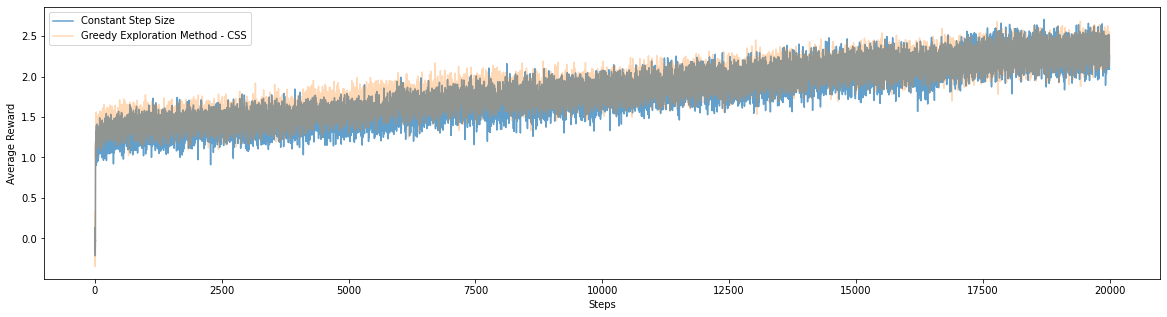

In [770]:
from cProfile import label


plt.figure(figsize=(20,5))

sns.lineplot(x_axis_steps2, astep_avg_average_rewards, alpha = .7)
sns.lineplot(x_axis_steps2, astep_expr_avg_average_rewards, alpha = .3)
plt.xlabel('Steps')
plt.ylabel('Average Reward')
plt.legend(labels =[#'Typical Exploration Method',#'Greedy Exploration Method', 
'Constant Step Size','Greedy Exploration Method - CSS'])
plt.show;

In [771]:
astep_optimal_percent = np.zeros(trial_steps)
for i in range(0,len(astep_all_optimals.transpose())):
    astep_optimal_percent[i] = sum(astep_all_optimals.transpose()[i])/100

astep_expr_optimal_percent = np.zeros(trial_steps)
for i in range(0,len(astep_expr_all_optimals.transpose())):
    astep_expr_optimal_percent[i] = sum(astep_expr_all_optimals.transpose()[i])/100



C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Joe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


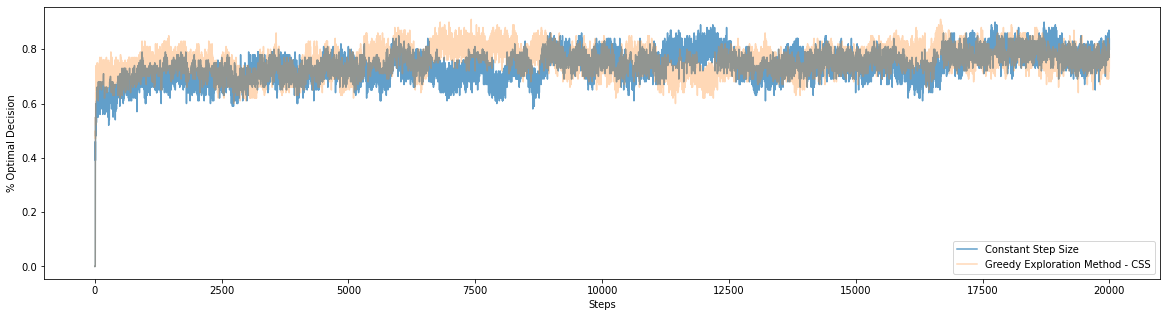

In [772]:
plt.figure(figsize=(20,5))

sns.lineplot(x_axis_steps2, astep_optimal_percent, alpha = .7)
sns.lineplot(x_axis_steps2, astep_expr_optimal_percent, alpha = .3)
plt.xlabel('Steps')
plt.ylabel('% Optimal Decision')
plt.legend(labels =[#'Typical Exploration Method','Greedy Exploration Method', 
'Constant Step Size', 'Greedy Exploration Method - CSS'])
plt.show;

In [793]:
data_table2 = pd.DataFrame({
    'Model': ['Simple Average Method','Constant Step-Size Method', 'Simple Greedy Exploration', 'Constant Step-Size Greedy Exploration'], 'Average Reward' : [sum(incr_average_rewards)/len(incr_average_rewards), 
    sum(astep_average_rewards)/len(astep_average_rewards), sum(expr_average_rewards)/len(expr_average_rewards), sum(astep_expr_average_rewards)/len(astep_expr_average_rewards)],
    'Average Optimal Action Percentage' : [sum(incr_optimal_counts)/cycles/len(incr_optimal_counts), sum(astep_optimal_counts)/cycles/(len(astep_optimal_counts)*2), sum(expr_optimal_counts)/cycles/len(expr_optimal_counts), 
    sum(astep_expr_optimal_counts)/cycles/(len(astep_expr_optimal_counts)*2)], 'Steps' : ['10,000','20,000','10,000','20,000']

})

In [794]:
data_table2

,Model,Average Reward,Average Optimal Action Percentage,Steps
0,Simple Average Method,1.603003,65.73460,"10,000"
1,Constant Step-Size Method,1.796950,74.03120,"20,000"
2,Simple Greedy Exploration,1.652320,67.24240,"10,000"
3,Constant Step-Size Greedy Exploration,1.872770,75.76335,"20,000"


In [778]:
data_table

,Model,Average Reward,Average Optimal Action Percentage
0,Simple Average Method,1.603003,65.7346
1,Constant Step-Size Method,1.660574,73.0773


In [783]:
greed_e = pd.DataFrame(
    {
        'Action Selection' : ['Exploit','Greedy Exploration','Exploration'], 'Probability' :['1-Epsilon', 'Epsilon x C', 'Epsilon x (1-C)']
    }
)

In [784]:
greed_e

,Action Selection,Probability
0,Exploit,1-Epsilon
1,Greedy Exploration,Epsilon x C
2,Exploration,Epsilon x (1-C)


In [790]:
data_table2.loc[data_table2['Model'].isin(['Constant Step-Size Greedy Exploration','Constant Step-Size Method'])]

,Model,Average Reward,Average Optimal Action Percentage
1,Constant Step-Size Method,1.79695,74.03120
3,Constant Step-Size Greedy Exploration,1.87277,75.76335


In [791]:
data_table2.loc[data_table2['Model'].isin(['Simple Average Method','Simple Greedy Exploration'])]

,Model,Average Reward,Average Optimal Action Percentage
0,Simple Average Method,1.603003,65.7346
2,Simple Greedy Exploration,1.652320,67.2424
